# Simple neural network

Standard training process for neural network:

1. define the network
2. iterate through an input dataset
3. process input dataset
4. compute the loss
5. propogate gradients back through the network
6. update weights

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# simple feed forward cnn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 convolution
        ## convolutions
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        ## fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # max pool 2x2 window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
net = Net()
print(net)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [14]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [15]:
input = Variable(torch.randn(1, 1, 32, 32))
out = net(input)
print(out)

Variable containing:
 0.0564  0.0013  0.0047 -0.0280  0.0478  0.0274 -0.1044  0.0103  0.0243  0.1120
[torch.FloatTensor of size 1x10]



In [16]:
# zero out params & backprops
net.zero_grad()
out.backward(torch.randn(1, 10))

Classes covered:

- **torch.Tensor** a _multi-dimensional_ array
- **autograd.Variable** _wraps a tensor_ and records history of operations applied to it
- **nn.Module** _neural network module_; convenient envelope for parameters
- **nn.Parameter** kind of Variable, automatically registered as a parameter when assigned as an attribute to a Module
- **autograd.Function** implements _forward and backward definitions of an autograd operation_

## Loss function

the loss function takes the output and target as inputs, computes a value that estiamtes the distance between them. several loss functions are available in the **nn** package.

In [17]:
output = net(input)
target = Variable(torch.arange(1, 11))
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

Variable containing:
 38.2921
[torch.FloatTensor of size 1]



In [18]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

## Backprop

backpropogate the error by calling **loss.backward()**. we need to clear the existing gradients beforehand otherwise we risk contaminating the update with existing gradients.

In [20]:
net.zero_grad()

print("conv1.bias.grad before backward")
print(net.conv1.bias.grad)

loss.backward()

print("conv1.bias.grad after backward")
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
1.00000e-02 *
  9.0278
 -7.6234
 -0.4759
 -0.7249
  5.0679
  1.1339
[torch.FloatTensor of size 6]



## Update the weights

simplest update rule used in practice is the SGD

_weight = weight - learning_rate * gradient_

which can be implemented by the following code:

In [21]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

however as you use NN's you'll want to use various update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. these can be found within **torch.optim**.

In [22]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

# Training a classifier

**torchvision** has loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc., as well as data transformers for images.

training an image classifier will require the following steps:

1. load & normalize the CIFAR10 dataset from **torchvision**
2. define a CNN
3. define a loss function
4. train the network
5. test the network

## 1. load & normalize CIFAR10 dataset

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

In [25]:
# transform images in the dataset to tensors with a normalized range
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [26]:
# showing some training images
import matplotlib.pyplot as plt
import numpy as np

def imgshow(img):
    # de-normalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# grab some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

  cat   dog truck horse


## 2. define a CNN

using the prior network but modifying it to take a 3 channel image instead of the 1 channel image as it was originally defined

In [27]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutions & pooling
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
net = Net()

## 3. define loss function

In [30]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. train the network

In [31]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data
        
        # wrap in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero out gradients
        optimizer.zero_grad()
        
        # forward, backward, optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.
            
print("Finished")

[1,  2000] loss: 2.205
[1,  4000] loss: 1.844
[1,  6000] loss: 1.676
[1,  8000] loss: 1.564
[1, 10000] loss: 1.494
[1, 12000] loss: 1.441
[2,  2000] loss: 1.392
[2,  4000] loss: 1.340
[2,  6000] loss: 1.333
[2,  8000] loss: 1.306
[2, 10000] loss: 1.281
[2, 12000] loss: 1.279
Finished


## 5. evaluate the network

Ground truth:   cat  ship  ship plane


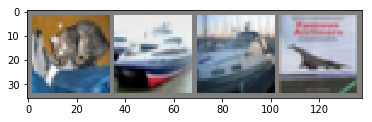

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images))
print("Ground truth: {}".format(" ".join('%5s' % classes[labels[j]] for j in range(4))))

In [33]:
outputs = net(Variable(images))

In [36]:
_, predicted = torch.max(outputs.data, 1)
print("Predicted: {}".format(" ".join('%5s' % classes[predicted[j]] for j in range(4))))

Predicted:   cat  ship  ship plane


In [38]:
# evaluating on the entire data set
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print("Accuracy over 10k test images: {}%".format(100 * correct / total))

Accuracy over 10k test images: 55%


In [39]:
# evaluating accuracy per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 63.8%
Accuracy of car: 64.2%
Accuracy of bird: 52.1%
Accuracy of cat: 38.4%
Accuracy of deer: 45.7%
Accuracy of dog: 31.7%
Accuracy of frog: 76.0%
Accuracy of horse: 56.4%
Accuracy of ship: 72.1%
Accuracy of truck: 54.8%
